#### Criando insights em case com dados de uma empresa de fibra óptica fictícia

De inicio começo importando as bibliotecas para o tratamento dos dados e criação de insights

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re

Carregando a "amostra_360" para o df

In [40]:
df = pd.read_excel('amostra_360.xlsx')

Visualizando o df

In [41]:
df.head()

,base_origem_hp,last_update_hp,id_hp_survey,no_viabilidade_hp,ds_estacao_abastecedora_hp,cd_tipo_survey_hp,hc_max,ds_uf_hp,ds_municipio_hp,nu_id_endereco_hp,...,f56_,f57_,f58_,f59_,f60_,f61_,f62_,matricula_tecnico_desbloqueio,ic_venda_valida,f63_
0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não,2023-02-27 11:52:35.318683
2,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
3,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
4,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683


In [42]:
df.info() #Solicitando informações do df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 256 entries, base_origem_hp to f63_
dtypes: datetime64[ns](4), float64(85), int64(4), object(163)
memory usage: 97.7+ MB


In [43]:
df.isnull().sum() #Consultando celulas vazias por coluna

base_origem_hp                    6271
last_update_hp                    6271
id_hp_survey                      6271
no_viabilidade_hp                 6271
ds_estacao_abastecedora_hp        6272
                                 ...  
f61_                             50000
f62_                             50000
matricula_tecnico_desbloqueio    50000
ic_venda_valida                      0
f63_                                 0
Length: 256, dtype: int64

In [44]:
df.dropna(axis = 1, how = 'all') #Removendo colunas completamente vazias

,base_origem_hp,last_update_hp,id_hp_survey,no_viabilidade_hp,ds_estacao_abastecedora_hp,cd_tipo_survey_hp,hc_max,ds_uf_hp,ds_municipio_hp,nu_id_endereco_hp,...,tipo_ordem_desbloqueio,status_ordem_desbloqueio,f53_,f54_,f55_,cd_pendencia_desbloqueio,ds_pendencia_desbloqueio,tipo_pendencia_desbloqueio,ic_venda_valida,f63_
0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não,2023-02-27 11:52:35.318683
2,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
3,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
4,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,vtal-data-lake.raw.stg_netwin_exp_enderecos_to...,2023-02-27,R305949,Viável,NLP,EDIFICACAO COMPLETA,2.0,RJ,NILÓPOLIS,3920761.0,...,FIBRA_DESBLOQUEIO_ORDEM,COMPLETED,2022-12-05 20:45:45+00,2022-12-05 20:45:45+00,2022-12-05 20:46:13+00,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
49996,vtal-data-lake.raw.stg_netwin_exp_enderecos_to...,2023-02-27,W324958,Viável,RSL,MORADIA,1.0,SC,RIO DO SUL,48717126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
49997,vtal-data-lake.raw.stg_netwin_exp_enderecos_to...,2023-02-27,T1344496,Viável,IJI,MORADIA,1.0,RS,IJUÍ,66617362.0,...,FIBRA_DESBLOQUEIO_ORDEM,COMPLETED,2022-08-23 17:33:53+00,2022-08-23 17:33:53+00,2022-08-23 17:34:21+00,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
49998,vtal-data-lake.raw.stg_netwin_exp_enderecos_to...,2023-02-27,I158513,Viável,SIS,MORADIA,1.0,MA,SANTA INÊS,28036488.0,...,FIBRA_DESBLOQUEIO_ORDEM,COMPLETED,2022-08-20 05:59:07+00,2022-08-20 05:59:07+00,2022-08-20 05:59:25+00,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683


#### 54 colunas foram removidas.

In [45]:
df.isnull().sum()

base_origem_hp                    6271
last_update_hp                    6271
id_hp_survey                      6271
no_viabilidade_hp                 6271
ds_estacao_abastecedora_hp        6272
                                 ...  
f61_                             50000
f62_                             50000
matricula_tecnico_desbloqueio    50000
ic_venda_valida                      0
f63_                                 0
Length: 256, dtype: int64

In [46]:
df.dropna(axis = 1, thresh = 11) #thresh para remover colunas com apenas 11 numeros

,base_origem_hp,last_update_hp,id_hp_survey,no_viabilidade_hp,ds_estacao_abastecedora_hp,cd_tipo_survey_hp,hc_max,ds_uf_hp,ds_municipio_hp,nu_id_endereco_hp,...,tipo_ordem_desbloqueio,status_ordem_desbloqueio,f53_,f54_,f55_,cd_pendencia_desbloqueio,ds_pendencia_desbloqueio,tipo_pendencia_desbloqueio,ic_venda_valida,f63_
0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Não,2023-02-27 11:52:35.318683
2,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
3,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
4,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,vtal-data-lake.raw.stg_netwin_exp_enderecos_to...,2023-02-27,R305949,Viável,NLP,EDIFICACAO COMPLETA,2.0,RJ,NILÓPOLIS,3920761.0,...,FIBRA_DESBLOQUEIO_ORDEM,COMPLETED,2022-12-05 20:45:45+00,2022-12-05 20:45:45+00,2022-12-05 20:46:13+00,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
49996,vtal-data-lake.raw.stg_netwin_exp_enderecos_to...,2023-02-27,W324958,Viável,RSL,MORADIA,1.0,SC,RIO DO SUL,48717126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
49997,vtal-data-lake.raw.stg_netwin_exp_enderecos_to...,2023-02-27,T1344496,Viável,IJI,MORADIA,1.0,RS,IJUÍ,66617362.0,...,FIBRA_DESBLOQUEIO_ORDEM,COMPLETED,2022-08-23 17:33:53+00,2022-08-23 17:33:53+00,2022-08-23 17:34:21+00,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683
49998,vtal-data-lake.raw.stg_netwin_exp_enderecos_to...,2023-02-27,I158513,Viável,SIS,MORADIA,1.0,MA,SANTA INÊS,28036488.0,...,FIBRA_DESBLOQUEIO_ORDEM,COMPLETED,2022-08-20 05:59:07+00,2022-08-20 05:59:07+00,2022-08-20 05:59:25+00,NaN,NaN,NaN,Sim,2023-02-27 11:52:35.318683


Muitos dados em branco e fica dificil utilização da função "dropna". Sendo assim crio um df com colunas relevante para seguir com o tratamento de dados.

In [47]:
list_columns = ['cd_tipo_survey_hp', 'ic_venda', 'velocidade_hc', 'ds_uf_hc', 'ds_municipio_hc', 'prestadora_servico', 'produto', 'dt_solicitacao', 'dt_instalacao', 'status_ordem_instalacao']
df_analytics = df[list_columns]
df_analytics

,cd_tipo_survey_hp,ic_venda,velocidade_hc,ds_uf_hc,ds_municipio_hc,prestadora_servico,produto,dt_solicitacao,dt_instalacao,status_ordem_instalacao
0,NaN,1,200MBPS,PA,BELÉM,NaN,VELOC_200MBPS,2023-01-15,2999-01-01 00:00:00,CANCELLED
1,NaN,1,400 MBPS,RS,SANTA MARIA,SEREDE,Dual Play Fibra BL + VoIP,2022-08-09,2999-01-01 00:00:00,CANCELLED
2,NaN,1,400 MBPS,BA,SALVADOR,CONECTA,Dual Play Fibra BL + VoIP,2022-10-27,2999-01-01 00:00:00,CANCELLED
3,NaN,1,500 MBPS,PR,CURITIBA,SEREDE,Dual Play Fibra BL + VoIP,2022-11-10,2999-01-01 00:00:00,CANCELLED
4,NaN,1,400 MBPS,MG,BELO HORIZONTE,TELEMONT,Dual Play Fibra BL + VoIP,2022-10-05,2999-01-01 00:00:00,CANCELLED
...,...,...,...,...,...,...,...,...,...,...
49995,EDIFICACAO COMPLETA,1,200 MBPS,RJ,NILÓPOLIS,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-06 00:00:00,COMPLETED
49996,MORADIA,1,400 MBPS,SC,RIO DO SUL,SEREDE,Dual Play Fibra BL + VoIP,2022-07-01,2022-07-07 00:00:00,COMPLETED
49997,MORADIA,1,400 MBPS,RS,IJUÍ,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-08 00:00:00,COMPLETED
49998,MORADIA,1,400 MBPS,MA,SANTA INÊS,CONECTA,Dual Play Fibra BL + VoIP,2022-07-02,2022-07-04 00:00:00,COMPLETED


In [48]:
df_analytics.isnull().sum()

cd_tipo_survey_hp          6271
ic_venda                      0
velocidade_hc               127
ds_uf_hc                      0
ds_municipio_hc               0
prestadora_servico         1267
produto                       0
dt_solicitacao                0
dt_instalacao               145
status_ordem_instalacao       0
dtype: int64


## Tratamento de Dados

Como visto na função `isnull().sum()`, ainda temos algumas células vazias. Agora, preciso explicar as hipóteses levantadas que justificaram o tratamento dos dados por meio da exclusão das linhas com células vazias e a aplicação de um filtro para o status de instalação `"COMPLETED"`.

### Hipótese 1
No pior dos casos, se considerarmos que as linhas não convergem entre si, ainda assim o número de células vazias é muito menor que o número total de linhas. Portanto, foi considerado que sua exclusão não impacta significativamente a análise das amostras. Além disso, completar esses dados com valores aleatórios ou fazer a interpolação seria um processo trabalhoso que, provavelmente, não traria resultados tão significativos.

### Hipótese 2
Não posso considerar os dados de empresas que não possuem o status de instalação `"COMPLETED"`. Dessa forma, registros com status `"CANCELLED"` são descartados, pois o serviço não foi prestado, e o status `"IN_PROGRESS"` não me garante que o serviço não será cancelado antes de sua conclusão, como, por exemplo, a equipe chegar ao local para a instalação.

---

Com isso, optei por excluir as linhas com células vazias e aplicar um filtro na coluna `Status_Instalação` para manter apenas os registros com o status `"PLETED"`.




In [49]:
df_analytics = df_analytics.dropna(axis=0)#Remolvo as linhas vazias que contem celulas vazias
df_analytics

,cd_tipo_survey_hp,ic_venda,velocidade_hc,ds_uf_hc,ds_municipio_hc,prestadora_servico,produto,dt_solicitacao,dt_instalacao,status_ordem_instalacao
1437,MORADIA,0,400 MBPS,RO,JARU,TELEMONT,Dual Play Fibra BL + VoIP,2022-12-06,2999-01-01 00:00:00,CANCELLED
1439,MORADIA,0,400 MBPS,MG,UBÁ,TELEMONT,Dual Play Fibra BL + VoIP,2022-10-11,2999-01-01 00:00:00,CANCELLED
1440,MORADIA,0,400 MBPS,MG,UBÁ,TELEMONT,Dual Play Fibra BL + VoIP,2022-10-28,2999-01-01 00:00:00,CANCELLED
1441,MORADIA,1,500 MBPS,MG,UBÁ,TELEMONT,Dual Play Fibra BL + VoIP,2022-11-11,2999-01-01 00:00:00,CANCELLED
1442,MORADIA,0,400 MBPS,RS,BAGÉ,SEREDE,Dual Play Fibra BL + VoIP,2023-02-08,2999-01-01 00:00:00,CANCELLED
...,...,...,...,...,...,...,...,...,...,...
49995,EDIFICACAO COMPLETA,1,200 MBPS,RJ,NILÓPOLIS,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-06 00:00:00,COMPLETED
49996,MORADIA,1,400 MBPS,SC,RIO DO SUL,SEREDE,Dual Play Fibra BL + VoIP,2022-07-01,2022-07-07 00:00:00,COMPLETED
49997,MORADIA,1,400 MBPS,RS,IJUÍ,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-08 00:00:00,COMPLETED
49998,MORADIA,1,400 MBPS,MA,SANTA INÊS,CONECTA,Dual Play Fibra BL + VoIP,2022-07-02,2022-07-04 00:00:00,COMPLETED


In [50]:
df_analytics.isnull().sum()

cd_tipo_survey_hp          0
ic_venda                   0
velocidade_hc              0
ds_uf_hc                   0
ds_municipio_hc            0
prestadora_servico         0
produto                    0
dt_solicitacao             0
dt_instalacao              0
status_ordem_instalacao    0
dtype: int64

In [51]:
#filtando o df apenas para o status de ordem "completo"
df_analytics = df_analytics.loc[df_analytics['status_ordem_instalacao']=='COMPLETED']
df_analytics

,cd_tipo_survey_hp,ic_venda,velocidade_hc,ds_uf_hc,ds_municipio_hc,prestadora_servico,produto,dt_solicitacao,dt_instalacao,status_ordem_instalacao
10001,EDIFICACAO COMPLETA,1,200 MBPS,MG,BETIM,TELEMONT,Dual Play Fibra BL + VoIP,2022-09-20,2022-09-24 00:00:00,COMPLETED
10002,MORADIA,1,400 MBPS,ES,SERRA,TELEMONT,Dual Play Fibra BL + VoIP,2023-01-23,2023-01-28 00:00:00,COMPLETED
10003,MORADIA,1,400 MBPS,PA,BELÉM,CONECTA,Dual Play Fibra BL + VoIP,2022-09-22,2022-09-29 00:00:00,COMPLETED
10004,MORADIA,1,50 MBPS,PA,BELÉM,CONECTA,Dual Play Fibra BL + VoIP,2022-11-14,2022-11-21 00:00:00,COMPLETED
10005,EDIFICACAO COMPLETA,1,200 MBPS,PA,BELÉM,SEREDE SERVICOS DE REDE S.A.,VELOC_200MBPS,2022-09-16,2022-09-21 00:00:00,COMPLETED
...,...,...,...,...,...,...,...,...,...,...
49995,EDIFICACAO COMPLETA,1,200 MBPS,RJ,NILÓPOLIS,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-06 00:00:00,COMPLETED
49996,MORADIA,1,400 MBPS,SC,RIO DO SUL,SEREDE,Dual Play Fibra BL + VoIP,2022-07-01,2022-07-07 00:00:00,COMPLETED
49997,MORADIA,1,400 MBPS,RS,IJUÍ,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-08 00:00:00,COMPLETED
49998,MORADIA,1,400 MBPS,MA,SANTA INÊS,CONECTA,Dual Play Fibra BL + VoIP,2022-07-02,2022-07-04 00:00:00,COMPLETED


In [52]:
#Usando a função rename para renomear as colunas do df_analytics
df_analytics = df_analytics.rename(columns={"cd_tipo_survey_hp": "Tipo_Local", "ic_venda": "Num_Vendas", "velocidade_hc": "Velocidade", "ds_uf_hc": "Estado", "ds_municipio_hc": "Municipio", "prestadora_servico": "Servico", "produto": "Produto", "dt_solicitacao": "Dt_Solicitacao", "dt_instalacao": "Dt_Instalacao", "status_ordem_instalacao": "Status_Instalacao"})
df_analytics

,Tipo_Local,Num_Vendas,Velocidade,Estado,Municipio,Servico,Produto,Dt_Solicitacao,Dt_Instalacao,Status_Instalacao
10001,EDIFICACAO COMPLETA,1,200 MBPS,MG,BETIM,TELEMONT,Dual Play Fibra BL + VoIP,2022-09-20,2022-09-24 00:00:00,COMPLETED
10002,MORADIA,1,400 MBPS,ES,SERRA,TELEMONT,Dual Play Fibra BL + VoIP,2023-01-23,2023-01-28 00:00:00,COMPLETED
10003,MORADIA,1,400 MBPS,PA,BELÉM,CONECTA,Dual Play Fibra BL + VoIP,2022-09-22,2022-09-29 00:00:00,COMPLETED
10004,MORADIA,1,50 MBPS,PA,BELÉM,CONECTA,Dual Play Fibra BL + VoIP,2022-11-14,2022-11-21 00:00:00,COMPLETED
10005,EDIFICACAO COMPLETA,1,200 MBPS,PA,BELÉM,SEREDE SERVICOS DE REDE S.A.,VELOC_200MBPS,2022-09-16,2022-09-21 00:00:00,COMPLETED
...,...,...,...,...,...,...,...,...,...,...
49995,EDIFICACAO COMPLETA,1,200 MBPS,RJ,NILÓPOLIS,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-06 00:00:00,COMPLETED
49996,MORADIA,1,400 MBPS,SC,RIO DO SUL,SEREDE,Dual Play Fibra BL + VoIP,2022-07-01,2022-07-07 00:00:00,COMPLETED
49997,MORADIA,1,400 MBPS,RS,IJUÍ,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-08 00:00:00,COMPLETED
49998,MORADIA,1,400 MBPS,MA,SANTA INÊS,CONECTA,Dual Play Fibra BL + VoIP,2022-07-02,2022-07-04 00:00:00,COMPLETED


In [53]:
df_analytics.reset_index(drop=True, inplace=True)#resetando o index de cada linhas

In [54]:
df_analytics

,Tipo_Local,Num_Vendas,Velocidade,Estado,Municipio,Servico,Produto,Dt_Solicitacao,Dt_Instalacao,Status_Instalacao
0,EDIFICACAO COMPLETA,1,200 MBPS,MG,BETIM,TELEMONT,Dual Play Fibra BL + VoIP,2022-09-20,2022-09-24 00:00:00,COMPLETED
1,MORADIA,1,400 MBPS,ES,SERRA,TELEMONT,Dual Play Fibra BL + VoIP,2023-01-23,2023-01-28 00:00:00,COMPLETED
2,MORADIA,1,400 MBPS,PA,BELÉM,CONECTA,Dual Play Fibra BL + VoIP,2022-09-22,2022-09-29 00:00:00,COMPLETED
3,MORADIA,1,50 MBPS,PA,BELÉM,CONECTA,Dual Play Fibra BL + VoIP,2022-11-14,2022-11-21 00:00:00,COMPLETED
4,EDIFICACAO COMPLETA,1,200 MBPS,PA,BELÉM,SEREDE SERVICOS DE REDE S.A.,VELOC_200MBPS,2022-09-16,2022-09-21 00:00:00,COMPLETED
...,...,...,...,...,...,...,...,...,...,...
39206,EDIFICACAO COMPLETA,1,200 MBPS,RJ,NILÓPOLIS,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-06 00:00:00,COMPLETED
39207,MORADIA,1,400 MBPS,SC,RIO DO SUL,SEREDE,Dual Play Fibra BL + VoIP,2022-07-01,2022-07-07 00:00:00,COMPLETED
39208,MORADIA,1,400 MBPS,RS,IJUÍ,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-08 00:00:00,COMPLETED
39209,MORADIA,1,400 MBPS,MA,SANTA INÊS,CONECTA,Dual Play Fibra BL + VoIP,2022-07-02,2022-07-04 00:00:00,COMPLETED


In [55]:
df_analytics.info()#agora verifico o dtype de cada coluna

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Tipo_Local         39211 non-null  object        
 1   Num_Vendas         39211 non-null  int64         
 2   Velocidade         39211 non-null  object        
 3   Estado             39211 non-null  object        
 4   Municipio          39211 non-null  object        
 5   Servico            39211 non-null  object        
 6   Produto            39211 non-null  object        
 7   Dt_Solicitacao     39211 non-null  datetime64[ns]
 8   Dt_Instalacao      39211 non-null  object        
 9   Status_Instalacao  39211 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 3.0+ MB


In [56]:
#transformando o dtype da coluna "Dt_Instalacao" de object para datetime
df_analytics["Dt_Instalacao"] = pd.to_datetime(df_analytics["Dt_Instalacao"])

In [57]:
df_analytics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Tipo_Local         39211 non-null  object        
 1   Num_Vendas         39211 non-null  int64         
 2   Velocidade         39211 non-null  object        
 3   Estado             39211 non-null  object        
 4   Municipio          39211 non-null  object        
 5   Servico            39211 non-null  object        
 6   Produto            39211 non-null  object        
 7   Dt_Solicitacao     39211 non-null  datetime64[ns]
 8   Dt_Instalacao      39211 non-null  datetime64[ns]
 9   Status_Instalacao  39211 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(7)
memory usage: 3.0+ MB


In [58]:
#criando coluna de duração para concluir o serviço
df_analytics['Duracao_Servico'] = df_analytics['Dt_Instalacao']-df_analytics['Dt_Solicitacao']

In [59]:
df_analytics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   Tipo_Local         39211 non-null  object         
 1   Num_Vendas         39211 non-null  int64          
 2   Velocidade         39211 non-null  object         
 3   Estado             39211 non-null  object         
 4   Municipio          39211 non-null  object         
 5   Servico            39211 non-null  object         
 6   Produto            39211 non-null  object         
 7   Dt_Solicitacao     39211 non-null  datetime64[ns] 
 8   Dt_Instalacao      39211 non-null  datetime64[ns] 
 9   Status_Instalacao  39211 non-null  object         
 10  Duracao_Servico    39211 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), int64(1), object(7), timedelta64[ns](1)
memory usage: 3.3+ MB


In [60]:
#transformo essa nova coluna de timedelta para int
df_analytics['Duracao_Servico'] = df_analytics['Duracao_Servico'].dt.days.astype(int)

In [61]:
df_analytics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Tipo_Local         39211 non-null  object        
 1   Num_Vendas         39211 non-null  int64         
 2   Velocidade         39211 non-null  object        
 3   Estado             39211 non-null  object        
 4   Municipio          39211 non-null  object        
 5   Servico            39211 non-null  object        
 6   Produto            39211 non-null  object        
 7   Dt_Solicitacao     39211 non-null  datetime64[ns]
 8   Dt_Instalacao      39211 non-null  datetime64[ns]
 9   Status_Instalacao  39211 non-null  object        
 10  Duracao_Servico    39211 non-null  int32         
dtypes: datetime64[ns](2), int32(1), int64(1), object(7)
memory usage: 3.1+ MB


In [62]:
df_analytics

,Tipo_Local,Num_Vendas,Velocidade,Estado,Municipio,Servico,Produto,Dt_Solicitacao,Dt_Instalacao,Status_Instalacao,Duracao_Servico
0,EDIFICACAO COMPLETA,1,200 MBPS,MG,BETIM,TELEMONT,Dual Play Fibra BL + VoIP,2022-09-20,2022-09-24,COMPLETED,4
1,MORADIA,1,400 MBPS,ES,SERRA,TELEMONT,Dual Play Fibra BL + VoIP,2023-01-23,2023-01-28,COMPLETED,5
2,MORADIA,1,400 MBPS,PA,BELÉM,CONECTA,Dual Play Fibra BL + VoIP,2022-09-22,2022-09-29,COMPLETED,7
3,MORADIA,1,50 MBPS,PA,BELÉM,CONECTA,Dual Play Fibra BL + VoIP,2022-11-14,2022-11-21,COMPLETED,7
4,EDIFICACAO COMPLETA,1,200 MBPS,PA,BELÉM,SEREDE SERVICOS DE REDE S.A.,VELOC_200MBPS,2022-09-16,2022-09-21,COMPLETED,5
...,...,...,...,...,...,...,...,...,...,...,...
39206,EDIFICACAO COMPLETA,1,200 MBPS,RJ,NILÓPOLIS,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-06,COMPLETED,3
39207,MORADIA,1,400 MBPS,SC,RIO DO SUL,SEREDE,Dual Play Fibra BL + VoIP,2022-07-01,2022-07-07,COMPLETED,6
39208,MORADIA,1,400 MBPS,RS,IJUÍ,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-08,COMPLETED,5
39209,MORADIA,1,400 MBPS,MA,SANTA INÊS,CONECTA,Dual Play Fibra BL + VoIP,2022-07-02,2022-07-04,COMPLETED,2


In [63]:
#observando a df_analytics a velocidade esta em object (valor da velocidade e sua unidade) e alguns dos dados estão escritos de forma diferente
#Sendo assim, uso a função apply em conjunto com lambda para substituir strigs por um espaço, tendo so numero nas celulas as transformo int
df_analytics['Velocidade'] = df_analytics['Velocidade'].apply(lambda x: re.sub('[^0-9]', '', str(x))).astype(int)

In [64]:
df_analytics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Tipo_Local         39211 non-null  object        
 1   Num_Vendas         39211 non-null  int64         
 2   Velocidade         39211 non-null  int32         
 3   Estado             39211 non-null  object        
 4   Municipio          39211 non-null  object        
 5   Servico            39211 non-null  object        
 6   Produto            39211 non-null  object        
 7   Dt_Solicitacao     39211 non-null  datetime64[ns]
 8   Dt_Instalacao      39211 non-null  datetime64[ns]
 9   Status_Instalacao  39211 non-null  object        
 10  Duracao_Servico    39211 non-null  int32         
dtypes: datetime64[ns](2), int32(2), int64(1), object(6)
memory usage: 3.0+ MB


In [65]:
#renomeio a coluna de velocidade, adicionando a unidade MBPS
df_analytics = df_analytics.rename(columns={'Velocidade': 'Velocidade_MBPS'})
df_analytics

,Tipo_Local,Num_Vendas,Velocidade_MBPS,Estado,Municipio,Servico,Produto,Dt_Solicitacao,Dt_Instalacao,Status_Instalacao,Duracao_Servico
0,EDIFICACAO COMPLETA,1,200,MG,BETIM,TELEMONT,Dual Play Fibra BL + VoIP,2022-09-20,2022-09-24,COMPLETED,4
1,MORADIA,1,400,ES,SERRA,TELEMONT,Dual Play Fibra BL + VoIP,2023-01-23,2023-01-28,COMPLETED,5
2,MORADIA,1,400,PA,BELÉM,CONECTA,Dual Play Fibra BL + VoIP,2022-09-22,2022-09-29,COMPLETED,7
3,MORADIA,1,50,PA,BELÉM,CONECTA,Dual Play Fibra BL + VoIP,2022-11-14,2022-11-21,COMPLETED,7
4,EDIFICACAO COMPLETA,1,200,PA,BELÉM,SEREDE SERVICOS DE REDE S.A.,VELOC_200MBPS,2022-09-16,2022-09-21,COMPLETED,5
...,...,...,...,...,...,...,...,...,...,...,...
39206,EDIFICACAO COMPLETA,1,200,RJ,NILÓPOLIS,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-06,COMPLETED,3
39207,MORADIA,1,400,SC,RIO DO SUL,SEREDE,Dual Play Fibra BL + VoIP,2022-07-01,2022-07-07,COMPLETED,6
39208,MORADIA,1,400,RS,IJUÍ,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-08,COMPLETED,5
39209,MORADIA,1,400,MA,SANTA INÊS,CONECTA,Dual Play Fibra BL + VoIP,2022-07-02,2022-07-04,COMPLETED,2


In [66]:
#Aqui percebo que para analisar os dados em mes e ano, preciso extrair esses dados da coluna "Dt_Solicitação"
#Sendo assim, tenho mes e ano em duas novas colunas
df_analytics['Mes'] = df_analytics['Dt_Solicitacao'].dt.strftime('%B')
df_analytics['Ano'] = df_analytics['Dt_Solicitacao'].dt.year
df_analytics

,Tipo_Local,Num_Vendas,Velocidade_MBPS,Estado,Municipio,Servico,Produto,Dt_Solicitacao,Dt_Instalacao,Status_Instalacao,Duracao_Servico,Mes,Ano
0,EDIFICACAO COMPLETA,1,200,MG,BETIM,TELEMONT,Dual Play Fibra BL + VoIP,2022-09-20,2022-09-24,COMPLETED,4,September,2022
1,MORADIA,1,400,ES,SERRA,TELEMONT,Dual Play Fibra BL + VoIP,2023-01-23,2023-01-28,COMPLETED,5,January,2023
2,MORADIA,1,400,PA,BELÉM,CONECTA,Dual Play Fibra BL + VoIP,2022-09-22,2022-09-29,COMPLETED,7,September,2022
3,MORADIA,1,50,PA,BELÉM,CONECTA,Dual Play Fibra BL + VoIP,2022-11-14,2022-11-21,COMPLETED,7,November,2022
4,EDIFICACAO COMPLETA,1,200,PA,BELÉM,SEREDE SERVICOS DE REDE S.A.,VELOC_200MBPS,2022-09-16,2022-09-21,COMPLETED,5,September,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39206,EDIFICACAO COMPLETA,1,200,RJ,NILÓPOLIS,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-06,COMPLETED,3,June,2022
39207,MORADIA,1,400,SC,RIO DO SUL,SEREDE,Dual Play Fibra BL + VoIP,2022-07-01,2022-07-07,COMPLETED,6,July,2022
39208,MORADIA,1,400,RS,IJUÍ,SEREDE,Dual Play Fibra BL + VoIP,2022-06-03,2022-06-08,COMPLETED,5,June,2022
39209,MORADIA,1,400,MA,SANTA INÊS,CONECTA,Dual Play Fibra BL + VoIP,2022-07-02,2022-07-04,COMPLETED,2,July,2022


#### Com o DataFrame tratado e pronto para gerar os insights, começo a utilizar as bibliotecas `matplotlib` e `plotly.express`.
#### Observe que, neste ponto, procuro gerar os insights da forma mais variada possível. Isso é proposital, com o intuito de demonstrar o conhecimento em diversas funções das respectivas bibliotecas


### Insights para visulizar as vendas de acordo com o tempo.

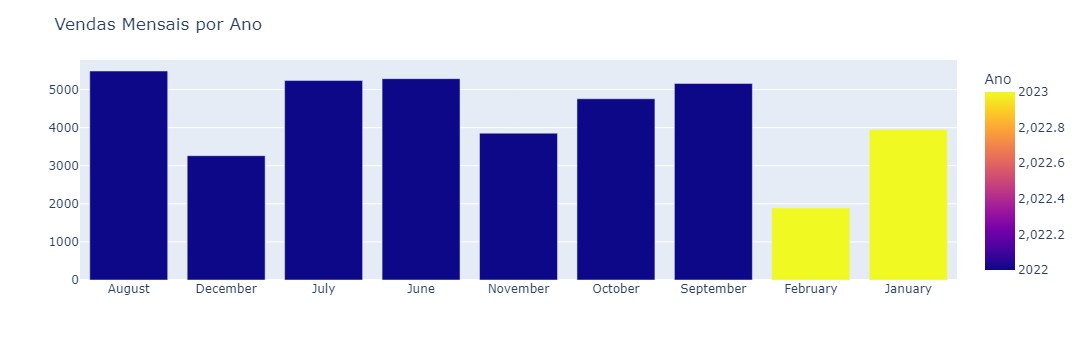

In [67]:

meses_vendas = df_analytics.groupby(['Ano', 'Mes'])['Num_Vendas'].sum().reset_index()

px.bar(meses_vendas, x='Mes', y='Num_Vendas', color= 'Ano').update_layout(title='Vendas Mensais por Ano').update_xaxes(title_text=None).update_yaxes(title_text=None)


#### Aqui é percepitivel que o mês de agosto, junho e julho de 2022 se destacou nas vendas. Por que será? O fatos desses meses fazerem parte da estação do ano de inverno. Pode ser uma justificativa, as pessoas passam mais o fim de semana em suas casas, aquelas que não tem internet porque passa pouquissimo tempo em casa e se satisfaz com os dados moveis, começam a necessitar de internet ? 
#### Outro ponto que chama atenção é a minima de vendas no mês de fevereiro, será que o verão contribui de forma oposta ao inverno?


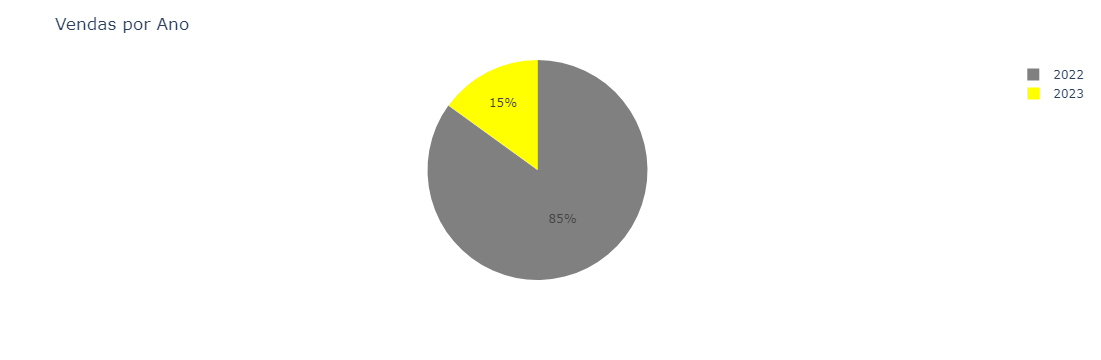

In [68]:
ano_vendas = df_analytics.groupby('Ano')['Num_Vendas'].sum()

colors = ['gray', 'yellow']

px.pie(ano_vendas, names = ano_vendas.index, values = ano_vendas.values, color_discrete_sequence=colors).update_layout(title='Vendas por Ano')

#### Por falta de dados não há como comparar os dados de 2022 e 2023.

#### Porém, apenas os dois primeiros meses de 2023 esta bem proximo de 2/12 do ano de 2022. O que leva a seguinte pergunta, nesse ritimo será que as vendas no ano de 2023 vão superar o ano anterior? 

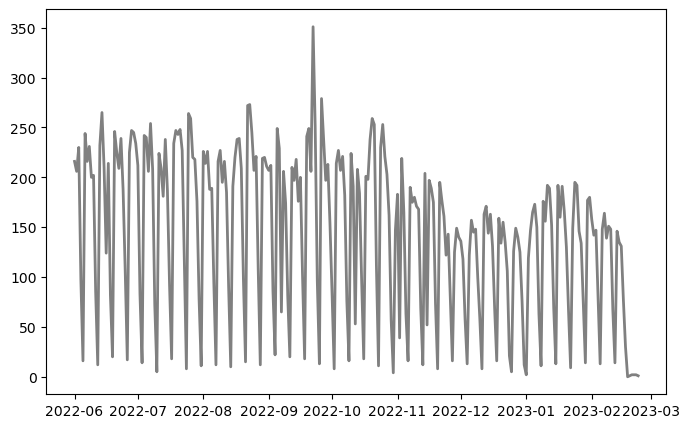

In [69]:
fig, ax = plt.subplots(figsize=(8,5))
colors = ['gray']

data_vendas = df_analytics.groupby('Dt_Solicitacao')['Num_Vendas'].sum()

ax.plot( data_vendas.index, data_vendas.values, color=colors[0], linewidth=2.0)
plt.show()

#### Aqui temos um grafico de linhas das vendas ao longo dos dias. Percebe-se uma diminuição no número de vendas por dia.

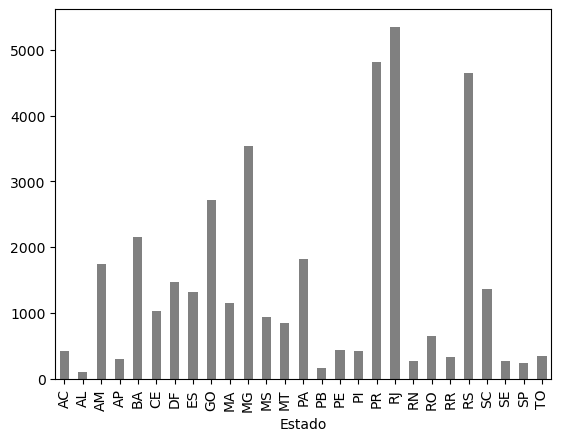

In [70]:
#Gerando grafico de vendas por estado
vendas_por_estado = df_analytics.groupby('Estado')['Num_Vendas'].sum()

vendas_por_estado.plot.bar(color='gray');

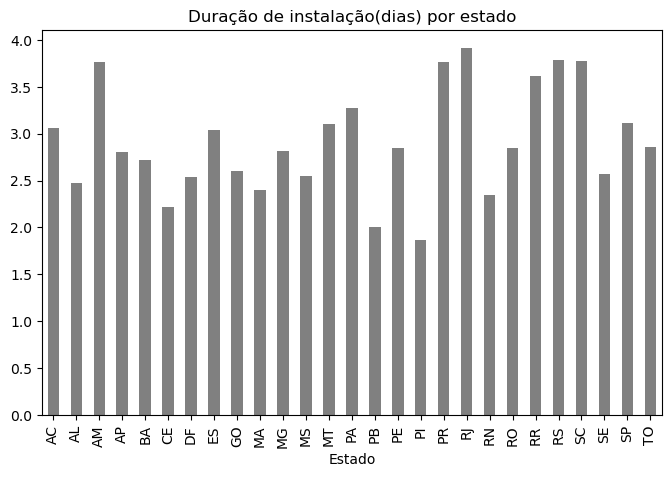

In [71]:
#Gerando grafico de duração de instalação por estado
fig, ax = plt.subplots(figsize=(8,5))

mean_duracao_estado = df_analytics.groupby('Estado')['Duracao_Servico'].mean()

mean_duracao_estado.plot.bar(color='gray', title = 'Duração de instalação(dias) por estado');

#### Nos gráficos de barras dos estados por vendas e duração de instalação. Percebe-se que nas regiões que temos um maior tempo de instalação, há uma deficiência de vendas.

#### Buscar parcerias com outros serviços do estado seria uma solução? Empresa que dispõe uma maior atenção aos clientes se destacam no mercado, agilidade na instação desso produto pode contribuir para uma maior fama na região consequentemente maior número de vendas.

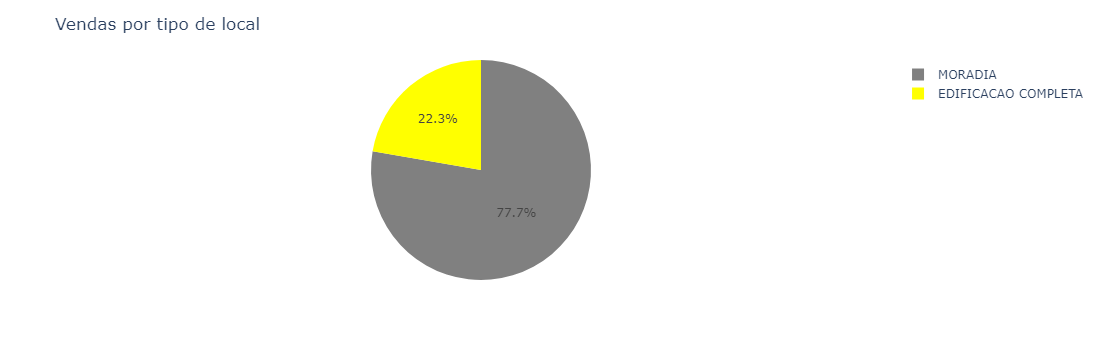

In [72]:
vendas_por_local = df_analytics.groupby('Tipo_Local')['Num_Vendas'].sum()

colors = ['gray', 'yellow']

px.pie(vendas_por_local, names = vendas_por_local.index, values = vendas_por_local.values, color_discrete_sequence=colors).update_layout(title='Vendas por tipo de local')

#### No gráfico de vendas por tipo de local, é notório uma dominância das vendas para moradia. E por mais que seja um grafico simples quer dizer muito. Com ele podemos obeserva o publico alvo das vendas. Direcionando assim estrategias de marketing para potencializar as vendas dos produtos, investindo em canais de marketing específicos e atigindo o público alvo.

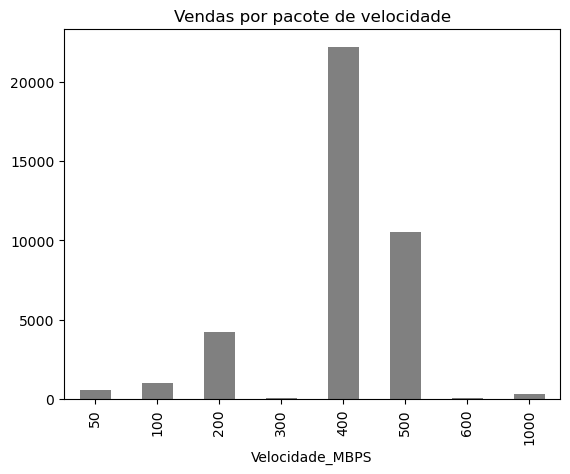

In [73]:
vendas_por_vel = df_analytics.groupby('Velocidade_MBPS')['Num_Vendas'].sum()
vendas_por_vel.plot.bar(color='gray', title='Vendas por pacote de velocidade');

#### Observe que o pacote de velocidade se destaca no número de vendas, provavelmente deve ser um pacote que atende as necessidades do cliente, o famoso custo beneficio. Aplicar esse pacote para outras regiões, a qual ele não esteja disponivel, ou tentativas de baratear os serviços de instalaçao podem potencializar as vendas.

<Axes: title={'center': 'Duração de instalação(dias) por Servico'}, xlabel='Servico'>

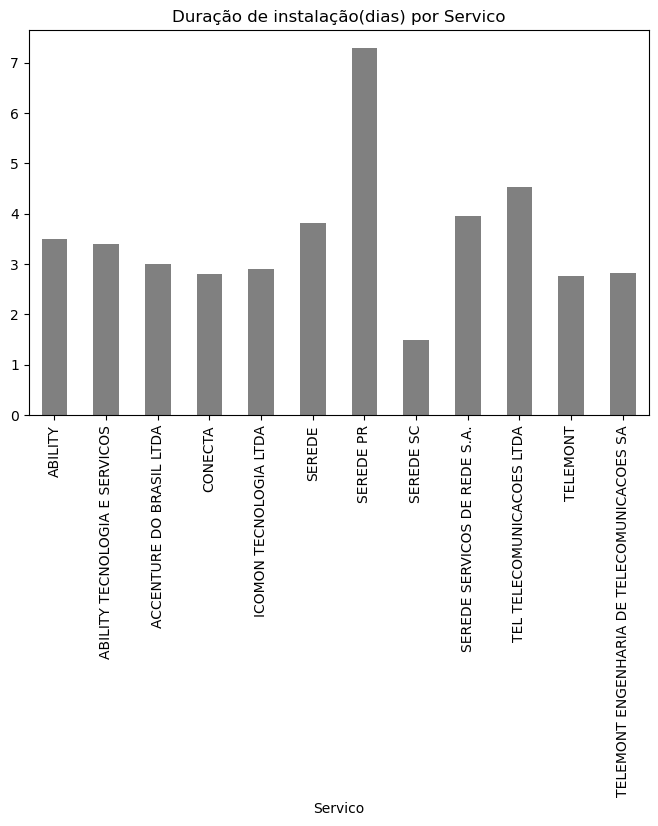

In [74]:
#Gerando grafico de duração de instalação por serviço
fig, ax = plt.subplots(figsize=(8,5))

mean_duracao_estado = df_analytics.groupby('Servico')['Duracao_Servico'].mean()

mean_duracao_estado.plot.bar(color='gray', title = 'Duração de instalação(dias) por Servico')

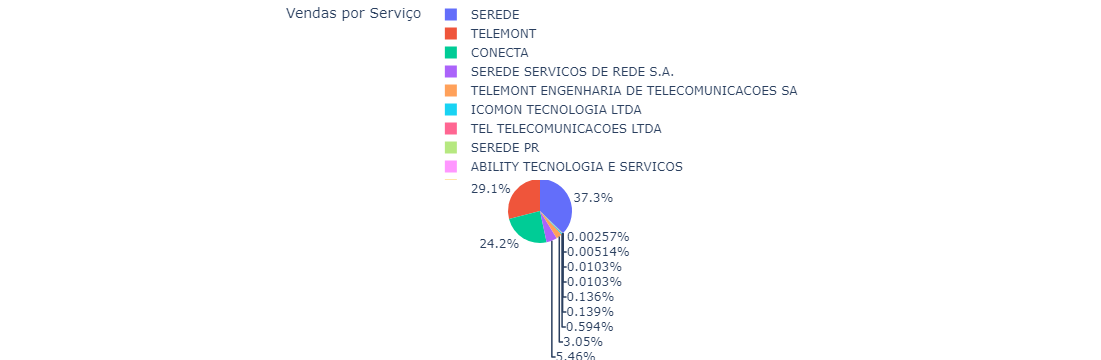

In [75]:
vendas_por_servico = df_analytics.groupby('Servico')['Num_Vendas'].sum()

px.pie(vendas_por_servico, names = vendas_por_servico.index, values = vendas_por_servico.values).update_layout(legend=dict(title='Vendas por Serviço', orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

#### Como dito ateriormente, prestação de serviço rápido passa ao cliente uma visão de atenção, ele se sente especial. E os dados não dizem o contrario. Observe a empresa prestadora de serviço "Serede" no gráfico pizza perceba como ela se destaca no número de vendas, sendo responsavel por quase 40% das vendas. Agora olhe o gráfico anterior de media de duração de instalação por serviço, justamente a empresa que se destaca é a SEREDE, com a menor média de tempo para prestar serviço

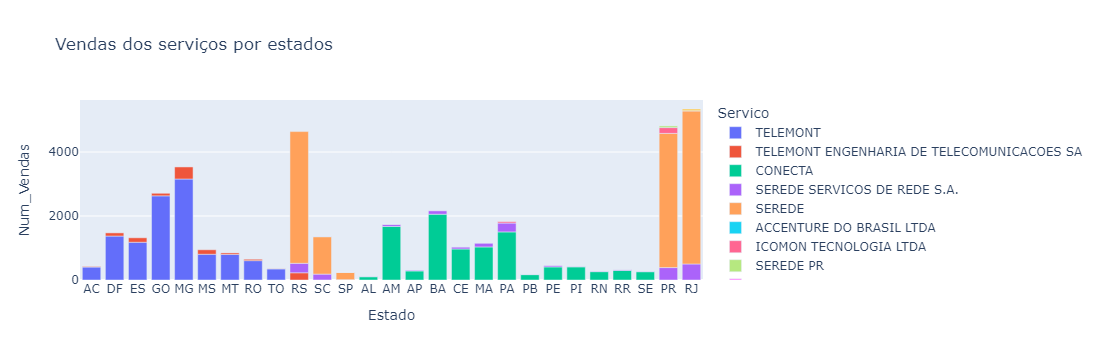

In [76]:
vendas_servico_estado = df_analytics.groupby(['Estado', 'Servico'])['Num_Vendas'].sum().reset_index()

px.bar(vendas_servico_estado, x = 'Estado', y = 'Num_Vendas', color = 'Servico', title = 'Vendas dos serviços por estados')

#### Nesse dois graficos, foi filtrado as vendas por serviços e as vendas por serviços nos estados. Sendo graficos que chamam muita atenção visto que, atitudes simples levam a grande resultando. Por exemplo,  buscar parcerias com as empresas Telemont, Conceta,  Serede e outras em outras regiões pode potencializar as vendas. Não só isso, pode ser feito parcerias com empresas com culturas parecidas com as de destaque. 